In [ ]:
#| default_exp examples

On this page, there are different toy examples demonstrating how you can apply `glycowork` to your projects! 
Here is a summary of the different available case studies: <br>

1. [Investigation of *N*-linked and *O*-linked glycosylation in fish](#example1)
2. [Glycan binding specificities of lectins](#example2)
3. [Glycan classification using machine learning models](#example3)
4. [Constructing and exploring biosynthetic networks](#example4)
5. [Deep Learning Code Snippets](#example5)
6. [GlycoDraw Code Snippets](#example6)

In [ ]:
#| include: false
from nbdev.showdoc import *
from IPython.display import HTML
import pandas as pd
import copy
import warnings
warnings.filterwarnings("ignore")
from glycowork.glycan_data.loader import df_species, glycan_binding, df_glycan, glycomics_data_loader
from glycowork.motif.analysis import plot_embeddings, get_heatmap, characterize_monosaccharide, get_pvals_motifs, get_differential_expression, get_volcano
from glycowork.motif.processing import presence_to_matrix
from glycowork.motif.query import get_insight
from glycowork.motif.draw import GlycoDraw
from glycowork.ml.model_training import train_ml_model, analyze_ml_model, get_mismatch
from glycowork.ml.train_test_split import general_split
from glycowork.network.biosynthesis import construct_network, plot_network, evoprune_network, highlight_network, net_dic, network_alignment
from glycowork.network.evolution import distance_from_metric, dendrogram_from_distance
#%load_ext autoreload
#%autoreload 2

# Example 1: Investigating *N*- and *O*-linked glycosylation in fish
<a class="anchor" id="example1"></a>

Suppose that after investigating glycans from plants as presented in the `core` module, you are now wondering how glycans from the Actinopterygii class (ray-finned fish) look like. To satisfy your curiosity, let's start with importing a dataset from `glycowork.glycan_data.loader.df_species` and putting a filter for fish glycans.

In [ ]:
df_fish = df_species[df_species.Class == 'Actinopterygii'].reset_index(drop = True)

In [ ]:
#| echo: false
df_fish2 = copy.deepcopy(df_fish)
df_fish2.set_index("glycan", inplace = True)
df_fish2.head().style.set_properties(**{'font-size': '11pt', 'font-family': 'Helvetica','border-collapse': 'collapse','border': '1px solid black'})

,Species,Genus,Family,Order,Class,Phylum,Kingdom,Domain,ref
glycan,,,,,,,,,
Gal(?1-?)[Gal(?1-?)]Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc,Acipenser_brevirostrum,Acipenser,Acipenseridae,Acipenseriformes,Actinopterygii,Chordata,Animalia,Eukarya,https://www.frontiersin.org/articles/10.3389/fmolb.2021.778383/full
Gal(?1-?)[Gal(?1-?)]Gal(b1-4)GlcNAc(b1-2)[Gal(?1-?)[Gal(?1-?)]Gal(b1-4)GlcNAc(b1-4)]Man(a1-3)[Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)[GlcNAc(b1-6)]Man(a1-6)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc,Acipenser_brevirostrum,Acipenser,Acipenseridae,Acipenseriformes,Actinopterygii,Chordata,Animalia,Eukarya,https://www.frontiersin.org/articles/10.3389/fmolb.2021.778383/full
Gal(?1-?)[Gal(?1-?)]Gal(b1-4)GlcNAc(b1-2)[GlcNAc(b1-4)]Man(a1-3)[Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Acipenser_oxyrinchus,Acipenser,Acipenseridae,Acipenseriformes,Actinopterygii,Chordata,Animalia,Eukarya,https://www.frontiersin.org/articles/10.3389/fmolb.2021.778383/full
Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Acipenser_oxyrinchus,Acipenser,Acipenseridae,Acipenseriformes,Actinopterygii,Chordata,Animalia,Eukarya,https://www.frontiersin.org/articles/10.3389/fmolb.2021.778383/full
Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)[Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-4)]Man(a1-3)[Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Acipenser_oxyrinchus,Acipenser,Acipenseridae,Acipenseriformes,Actinopterygii,Chordata,Animalia,Eukarya,https://www.frontiersin.org/articles/10.3389/fmolb.2021.778383/full


To have a better overview of the glycans similarities in fish, you can plot these data using `glycowork.motif.analysis.plot_embeddings`. The best option here, to visualize the data, is to color the dots by taxonomic family.  

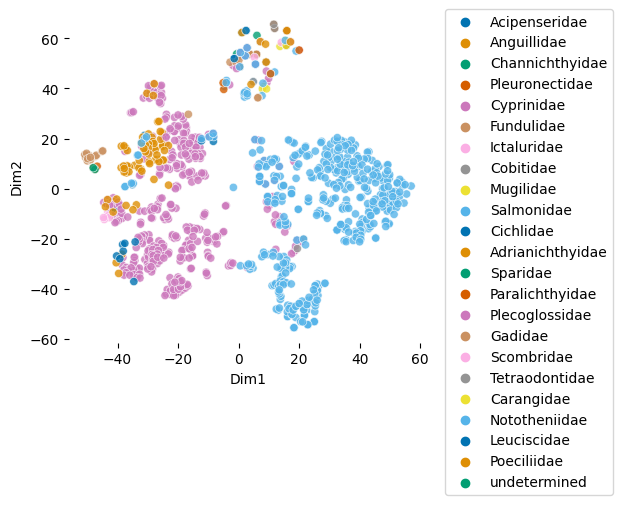

In [ ]:
plot_embeddings(df_fish.glycan.values.tolist(), label_list = df_fish.Family.values.tolist())

Interesting! First, the graph shows a large Salmonidae cluster in addition to a separate cluster of various families. <br> 

Now, let's focus on further analyses. We will first convert our data into a count table using `glycowork.motif.processing.presence_to_matrix` and then visualize the results. A heatmap can be generated using `glycowork.motif.analysis.get_heatmap`, and the `yticklabels = True` option allows us to display all the labels.

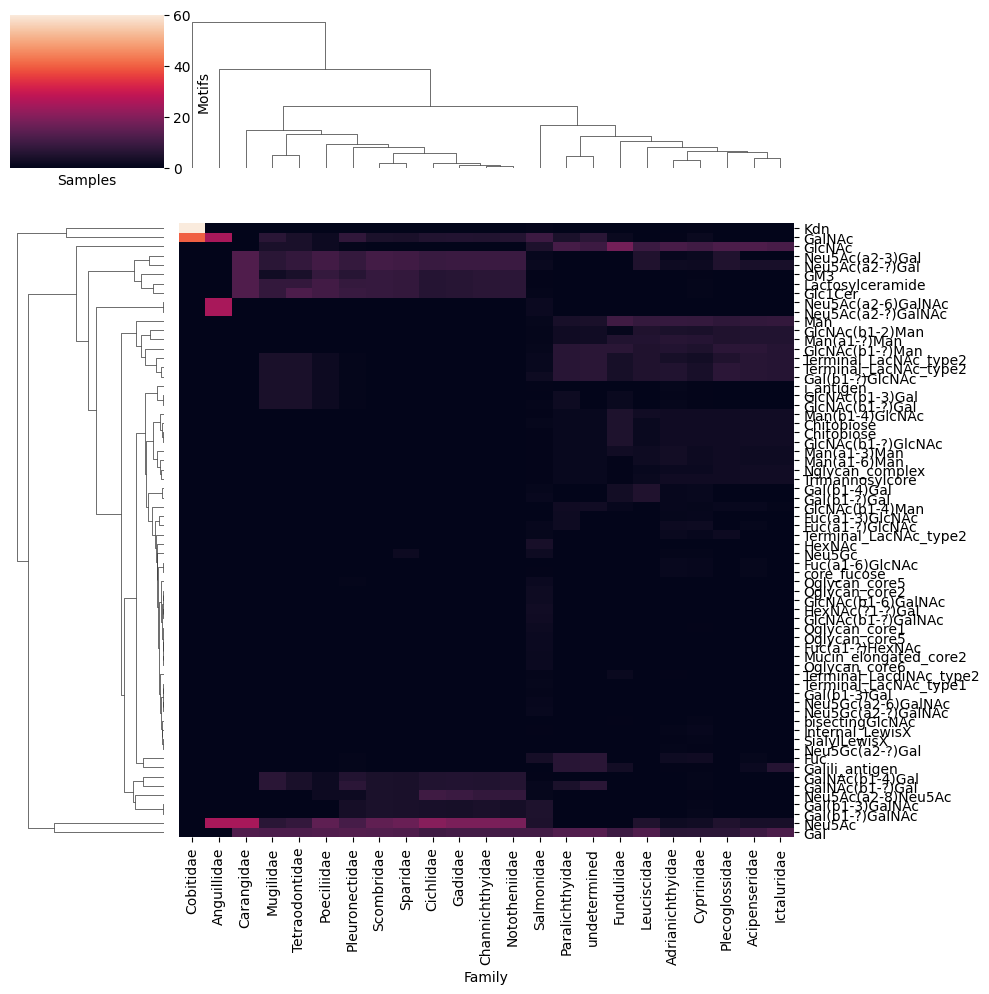

In [ ]:
df_map_fish = presence_to_matrix(df_fish, label_col_name = 'Family')
get_heatmap(df_map_fish, motifs = True, feature_set = ['known', 'exhaustive'], datatype = 'presence', yticklabels = True)

The first thing that catches the eye is the presence of a bunch of glycan motifs in Mugilidae to Cichlidae that are absent in the other classes. One hypothesis for this is that these families mainly contain glycosphingolipids in our database, while the other families focus on *N*-linked glycans (and Salmonidae + Cyprinidae have both as well-investigated families).<br>

To visualize which dots from the embedding plot correspond to glycosphingolipids, we can focus on 1Cer-containing glycans. We can map them again but with the additional option `shape_feature`. This parameter allows you to transform dots into crosses if the corresponding glycan contains the specified monosaccharide, modification, or linkage. 

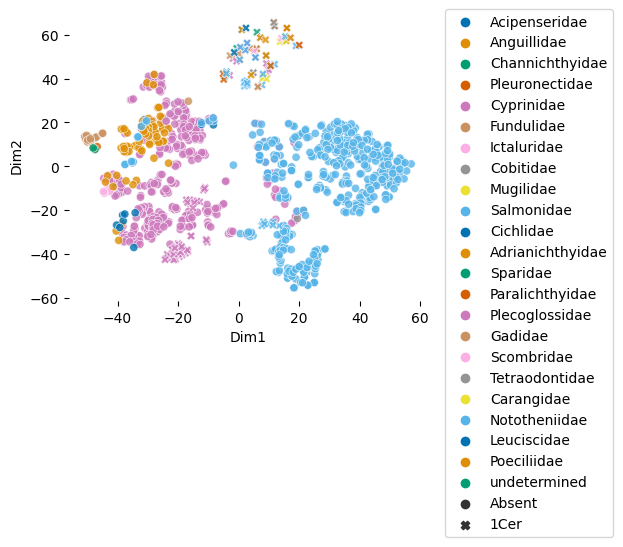

In [ ]:
plot_embeddings(df_fish.glycan.values.tolist(), label_list = df_fish.Family.values.tolist(), shape_feature = "1Cer")

As you can see, in `df_species`, 1Cer-containing glycans (crosses) are only present in one of the two clusters (in the class Actinopterygii). In this cluster, they in turn show enriched locations, presumably corresponding to certain groups of related glycans. <br> 

We can also use `glycowork` to take a look at the overall monosaccharide distribution in animal glycans. `glycowork.motif.analysis.characterize_monosaccharide` will be our best ally to learn what other monosaccharides, for instance, Gal variants are often connected to. <br>

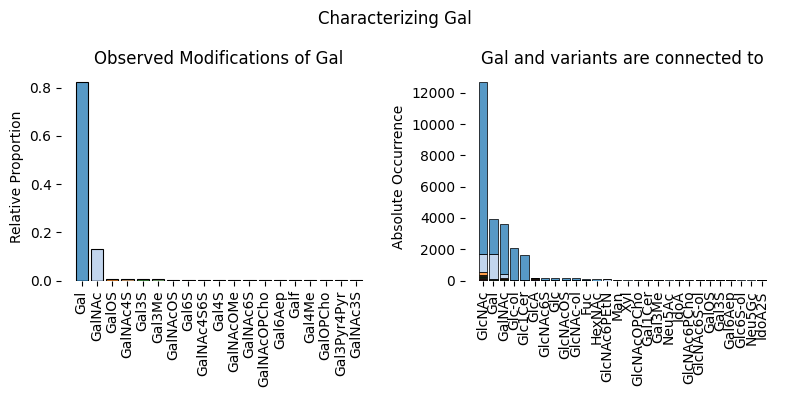

In [ ]:
characterize_monosaccharide('Gal', rank = 'Kingdom', focus = 'Animalia', modifications = True)

Running this analysis, it appears that Gal is found connected to GlcNAc as well as various other monosaccharides and that it does display several variants, including sulfurylated galactose. This is a completely different profile than we obtained for xylose in plant glycans! <br>

# Example 2: Glycan binding specificities of lectins
<a class="anchor" id="example2"></a>

For this second example, we will focus on a specific set of proteins, called lectins, that bind glycans in a sequence-specific manner. One example for lectins can be found in the hemagglutinin protein of influenza virus. Influenza viruses are well known as the biological agents responsible for the seasonal flu in humans. In general, viruses penetrate inside host cells thanks to a mechanism involving contacts between proteins and glycans. Surface proteins surrounding viruses and eukaryotic cells interact together and allow the entry of viral particles inside the targeted cells. However, different influenza strains may recognize different glycosylations on proteins more or less efficiently. <br>

To measure these glycan binding specificities, one can add virus particles to glycan arrays presenting immobilized glycans. Such a protocol allows screening for specific binding. From such data, we can then ask what are the glycans that are the most efficiently recognized by a given influenza virus? <br>

Fortunately, `glycowork` can be really helpful to answer such a question! The binding specificity of 1,392 lectins for a vast range of glycans is available in the `glycan_binding` dataset. Let's start by importing these data.

In [ ]:
#| echo: false
glycan_binding.head().style.set_properties(**{'font-size': '11pt', 'font-family': 'Helvetica','border-collapse': 'collapse','border': '1px solid black'})

,3-Anhydro-Gal(a1-3)Gal(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal2S(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3dGal(b1-3)[Fuc(a1-4)]Glc,3dGal(b1-4)Glc,4d8dNeu5Ac(a2-3)Gal(b1-4)Glc,4dNeu5Ac(a2-3)Gal(b1-4)Glc,7dNeu5Ac(a2-3)Gal(b1-4)Glc,8dNeu5Ac(a2-3)Gal(b1-4)Glc,9dNeu5Ac(a2-3)Gal(b1-4)Glc,Ara(a1-5)Ara(a1-5)Ara(a1-5)Ara(a1-5)Ara(a1-5)Ara,Ara(a1-5)Ara(a1-5)Ara(a1-5)Ara(a1-5)Ara(a1-5)Ara(a1-5)Ara,Fuc(a1-2)Gal,Fuc(a1-2)Gal(b1-3)GalNAc,Fuc(a1-2)Gal(b1-3)GalNAc(a1-3)[Fuc(a1-2)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GalNAc(a1-3)[Fuc(a1-2)]Gal(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-3)GalNAc(b1-3)Gal,Fuc(a1-2)Gal(b1-3)GalNAc(b1-3)Gal(a1-4)Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GalNAc(b1-3)Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GalNAc(b1-4)[Neu5Ac(a2-3)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GlcNAc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-3)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-3)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)GalNAc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)[Fuc(a1-2)Gal(b1-3)GlcNAc(b1-6)]GalNAc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)[Fuc(a1-2)]Gal(b1-4)GlcNAc(b1-6)[Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)[Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-6)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)[Gal(b1-4)GlcNAc(b1-6)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)[Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-6)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GlcNAc6S,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-3)Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-3)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-3)Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-3)[Fuc(a1-2)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-3)[Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-6)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-3)[Gal(b1-4)GlcNAc(b1-6)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-4)Glc6S,Fuc(a1-2)Gal(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-2)Man,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Gal(b1-4)GlcNAc(b1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-2)[Fuc(a1-2)Gal(b1-4)GlcNAc(b1-4)]Man(a1-3)[Fuc(a1-2)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-3)GalNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-3)[Fuc(a1-2)Gal(b1-4)GlcNAc(b1-6)]GalNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-3)[Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-6)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-6)GalNAc,Fuc(a1-2)Gal(b1-4)GlcNAc6S,Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GalNAc(b1-3)Gal(b1-4)[Fuc(a1-3)]GlcNAc,Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GalNAc(b1-3)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-3)Gal(b1-4)[Fuc(a1-3)]GalNAc,Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc,Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-2)Man(a1-6)]

As you can see, this dataset contains numerical values (Z-scores) corresponding to the ability of different lectins to bind different glycans. From these data, we can compute a heatmap with `get_heatmap`. The results should teach us whether some specific strains bind specific glycans. As we work with quantitative values, the `datatype` parameter must be set to `'response'`. If you want to include literature-annotated motifs (e.g., VIM, Lewis X, Blood group A), just add 'known' to the list of the feature_set. Let's see what kind of heatmap we can generate using this dataset.

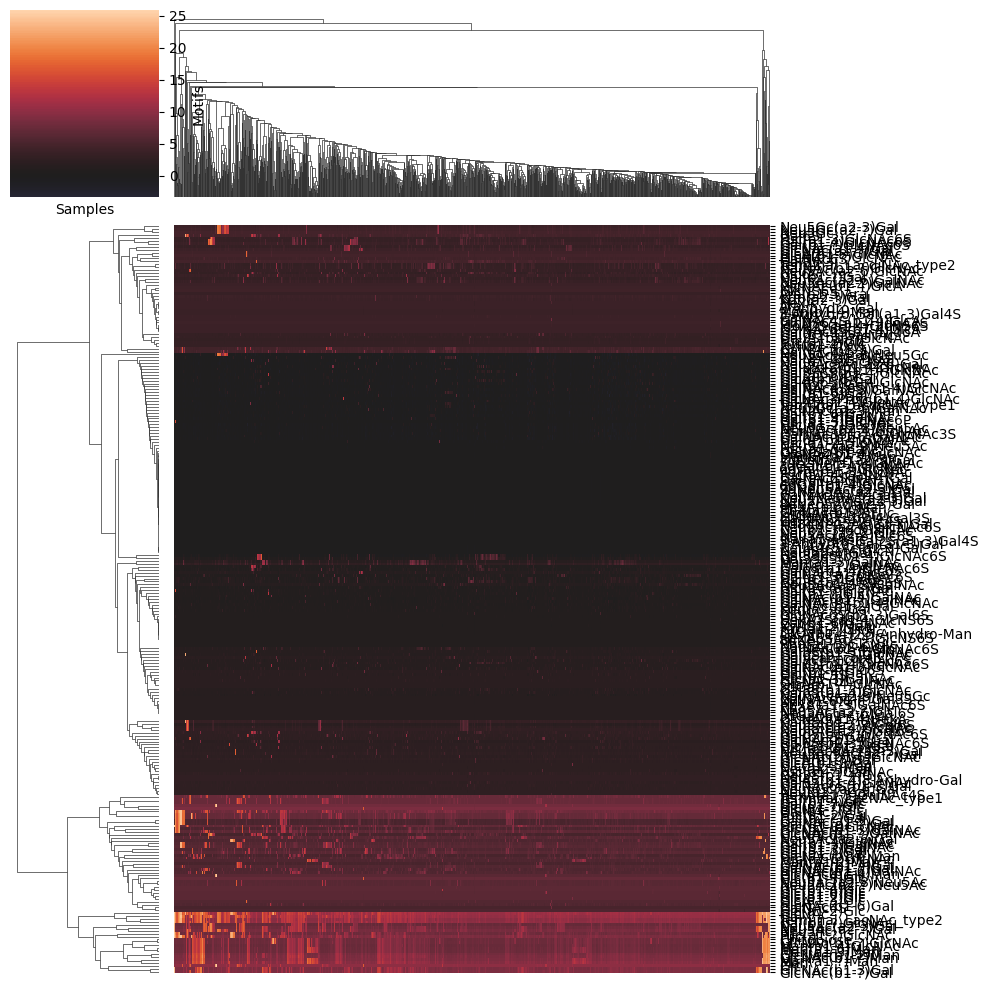

In [ ]:
get_heatmap(glycan_binding.iloc[:,:-2], motifs = True, feature_set = ['exhaustive'], datatype = 'response', yticklabels = 1,
            xticklabels = False)

In [ ]:
#| echo: false
import numpy as np
glycan_binding = glycan_binding.dropna(thresh = 1, axis=1).dropna(thresh = 1, axis = 0)
glycan_binding.iloc[:,:-2] = glycan_binding.iloc[:,:-2].clip(lower=0).replace(0,np.nan).astype(np.float32)

Due to the high number of lectins in this dataset, the heatmap is difficult to analyze in detail. However, we can clearly see that there are clusters of lectins recognizing specific glycan motifs. Examples include Neu5Ac(a2-6)Gal, Neu5Ac(a2-3)Gal, Fuc(a1-6)GlcNAc, and others. All these represent well-known glycan motifs with important roles in biology. <br>

Another way to analyze the glycan binding capacities of lectins is to use `glycowork.motif.analysis.get_pvals_motifs`. As we are working with data obtained from different proteins, we must also set `multiple_samples` to `True`.

In [ ]:
results = get_pvals_motifs(glycan_binding.iloc[:,:-1], feature_set = ['exhaustive'], multiple_samples = True)

In [ ]:
#| echo: false
results = results.applymap(str)
results[:25].style.set_properties(**{'font-size': '11pt', 'font-family': 'Helvetica',
                                          'border-collapse': 'collapse','border': '1px solid black'})

,motif,pval,corr_pval,effect_size
291,Neu5Ac(a2-?)Gal,0.0,0.0,0.2227152286335201
129,Gal(b1-4)GlcNAc,0.0,0.0,0.20540814942182287
137,Gal(b1-?)GlcNAc,0.0,0.0,0.18847937111342644
56,Neu5Ac,0.0,0.0,0.18423484873700716
38,GlcNAc,0.0,0.0,0.1816049427204201
18,Gal,0.0,0.0,0.16948355670089726
50,Man,0.0,0.0,0.1690490012740479
222,GlcNAc(b1-3)Gal,0.0,0.0,0.16556810520825838
258,Man(a1-3)Man,0.0,0.0,0.1643056508562803
262,Man(a1-?)Man,0.0,0.0,0.16347063165902484


These results indicate, for each motif, a p-value and a corrected p-value. These quantitative results support our qualitative observations from before. However, this represents a bird's eye view across all lectins in the dataset. A follow-up analysis might be to focus on a specific group of lectins, analyzing their binding patterns in depth.

# Example 3: Glycan classification using machine learning models
<a class="anchor" id="example3"></a>

The investigation of glycans from animals and viruses demonstrated how specific their presence in an organism can be. This particular characteristic can be exploited to predict the source of a given glycan among organisms. By classifying which glycans stem from which species/taxonomic groups, machine learning models can be trained to learn which motifs are enriched in which species, allowing for further insights. <br>

Let's see how we can use `glycowork` to classify human versus non-human primate glycans! First, we need to annotate each known glycan using a binary code where **1** means **human glycan** and **0** means **non-human primate glycan**. 

In [ ]:
human = [1 if k == 'Homo_sapiens' else 0 for k in df_species[df_species.Order=='Primates'].Species.values.tolist()]

Now, we have to generate two sets of glycans that we will use as train set and test set. In addition, we also need their corresponding sets with classes labelled as **0** or **1**. One way to do it is to use `glycowork.ml.train_test_split.general_split`. This function assigns the data with a 80/20 ratio to train and test sets respectively.

In [ ]:
X_train, X_test, y_train, y_test = general_split(df_species[df_species.Order=='Primates'].glycan.values.tolist(), human)

It is now time to train a machine learning model on these data! Different machine learning algorithms are available in `glycowork` and here we can use `glycowork.ml.model_training.train_ml_model`. This classification method uses a standard machine learning model (XGBoost) trained on short glycan motifs which may not be the most accurate, but can be sufficient for a preliminary exploration of our problem. Plus, it has the advantage of running faster than other more complex algorithms such as deep learning so... let's give it a try!

In [ ]:
model_ft, _, X_test = train_ml_model(X_train, X_test, y_train, y_test, feature_calc = True, feature_set = ['terminal'],
                         return_features = True)


Calculating Glycan Features...

Training model...

Evaluating model...
Accuracy of trained model on separate validation set: 0.8302047781569966


As you can see, even this (quite) simple algorithm is enough to reach around 83% prediction accuracy on the test set! It also confirms that glycan sequence is highly representative of their origin and allows to efficiently discriminate human from non-human primate glycans. <br>

One more step we can do is the analysis of the model we have generated. This is important, as we do not know yet what information is the most useful for the model to predict the origin of a glycan. The `glycowork.ml.model_training.analyze_ml_model` function can help us to understand on which basis the model predictions are made.

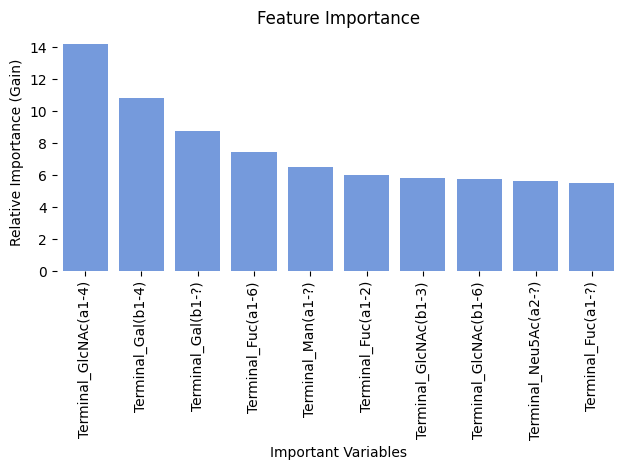

In [ ]:
analyze_ml_model(model_ft)

Interesting! It appears that the presence/absence of alpha-Gal and Neu5Gc are quite discriminative of its belonging to Homo sapiens or not! <br>

Next to knowing what is important for model prediction, it is often also crucial to know the limits of a model. In `glycowork`, you can use `glycowork.ml.model_training.get_mismatch` module to get a sense of wrong classifications. This could for instance inform you about potential model biases.

In [ ]:
get_mismatch(model_ft, X_test, y_test)

[('GlcNAc6S(b1-3)Gal(b1-4)Glc-ol', 0.8178003430366516),
 ('Fuc(a1-?)[Gal(b1-?)]GlcNAc(b1-2)[Fuc(a1-?)[Gal(b1-?)]GlcNAc(b1-4)]Man(a1-3)[Fuc(a1-?)[Gal(b1-?)]GlcNAc(b1-?)[GlcNAc(b1-?)]Man(a1-6)][GlcNAc(b1-4)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc',
  0.4119275212287903),
 ('Neu5Ac(a2-6)Gal(b1-?)[Fuc(a1-?)]GlcNAc(b1-?)[Gal(b1-?)GlcNAc(b1-?)]Man(a1-3)[Gal(b1-?)GlcNAc(b1-2)[Gal(b1-?)GlcNAc(b1-6)]Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc',
  0.6590214967727661),
 ('Man(a1-2)Man(a1-2)Man(a1-3)[Man(a1-2)Man(a1-6)[Man(a1-3)]Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc',
  0.7636852860450745),
 ('Man(a1-?)Man(a1-?)[Man(a1-?)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc',
  0.7674980759620667),
 ('Neu5Gc(a2-3)Gal(b1-4)Glc-ol', 0.5243940949440002),
 ('Gal(b1-3)[Neu5Ac(a2-6)]GlcNAc(b1-3)Gal(b1-4)Glc-ol', 0.7285189628601074),
 ('Man(a1-2)Man(a1-2)Man(a1-3)[Man(a1-2)Man(a1-6)[Man(a1-3)]Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc',
  0.7636852860450745),
 ('Neu5Ac(a2-3)Gal(b1-?)[Fuc(a1-?)]GlcNAc(b1-2)[Neu5Ac(a2-6)Gal(b1-?)[F

Here we can see that our model was especially confused by glycans which can occur in both types of orders and therefore are ambiguous for classification ambiguous. Maybe in these scenarios a more powerful, deep learning-based model might be able to differentiate (at least a bit better)! <br>

# Example 4: Constructing and exploring biosynthetic networks
<a class="anchor" id="example4"></a>

The `network` module of glycowork is designed to readily construct and analyze biosynthetic networks from a list of glycans in a very modular way. Below, this is illustrated with a fictional set of milk glycans (all default parameters of `construct_network` are optimized for milk glycans and should be changed for other glycan classes). Just inputting a list of biosynthetically related glycans into `glycowork.network.biosynthesis.construct_network` and then `glycowork.network.biosynthesis.plot_network` will build and plot our biosynthetic network! (depending on your browser etc, this might not render correctly)

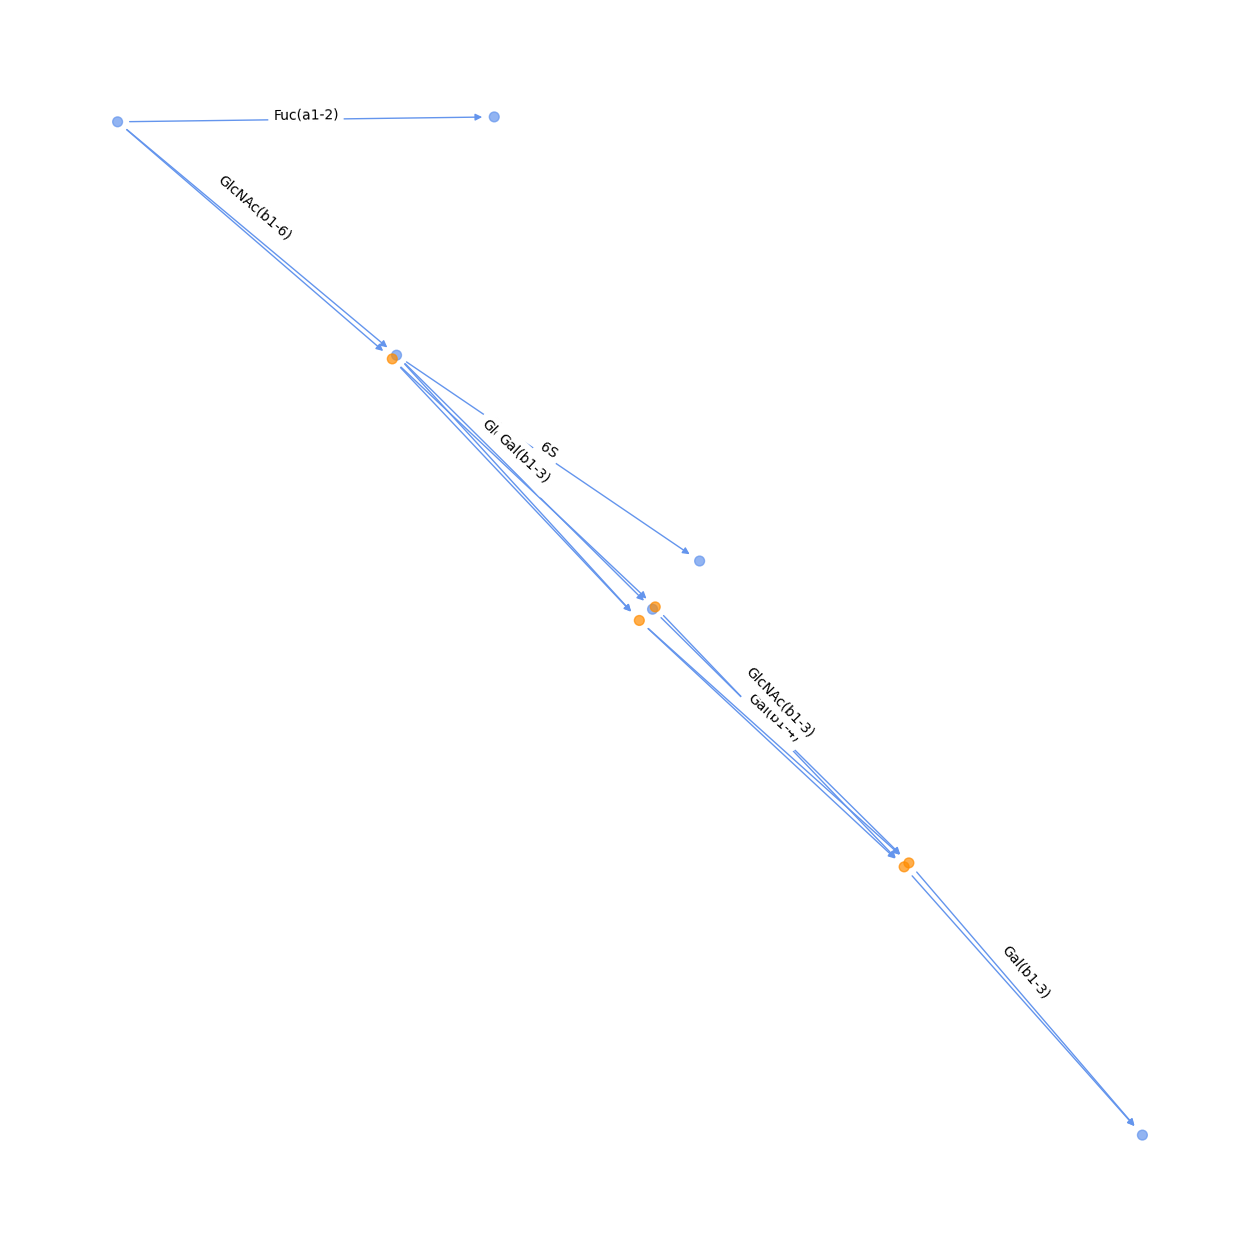

In [ ]:
glycans = ["Gal(b1-4)Glc-ol", "GlcNAc(b1-3)Gal(b1-4)Glc-ol",
           "GlcNAc6S(b1-3)Gal(b1-4)Glc-ol",
           "Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)Glc-ol", "Fuc(a1-2)Gal(b1-4)Glc-ol",
          "Gal(b1-4)GlcNAc(b1-3)[Gal(b1-3)GlcNAc(b1-6)]Gal(b1-4)Glc-ol"]
network = construct_network(glycans)
plot_network(network, plot_format = 'kamada_kawai')

We can see that, in these networks, every dot is a glycan (and can be hovered over to see its sequence) and every link is the addition of a monosaccharide in a defined linkage by an enzyme. Blue dots are glycans which we provided as input, orange glycans are inferred in order to connect the network. <br>

One thing you can immediately see is that there often are multiple paths to reach a blue dot, via several orange routes. This is because we don't know the order in which the monosaccharides have been added. We show in recent work that this order is highly conserved. Therefore, we could use knowledge gathered over decades in the breast milk of over a hundred mammalian species, to find out which order is realistic. <br>

`glycowork` can help you here as well, since it contains pre-computed biosynthetic networks for milk glycans of >100 mammalian species. We can use the `glycowork.network.biosynthesis.evoprune_network` function to use this information to prune our networks, removing paths that are evolutionarily very unlikely.

14
7


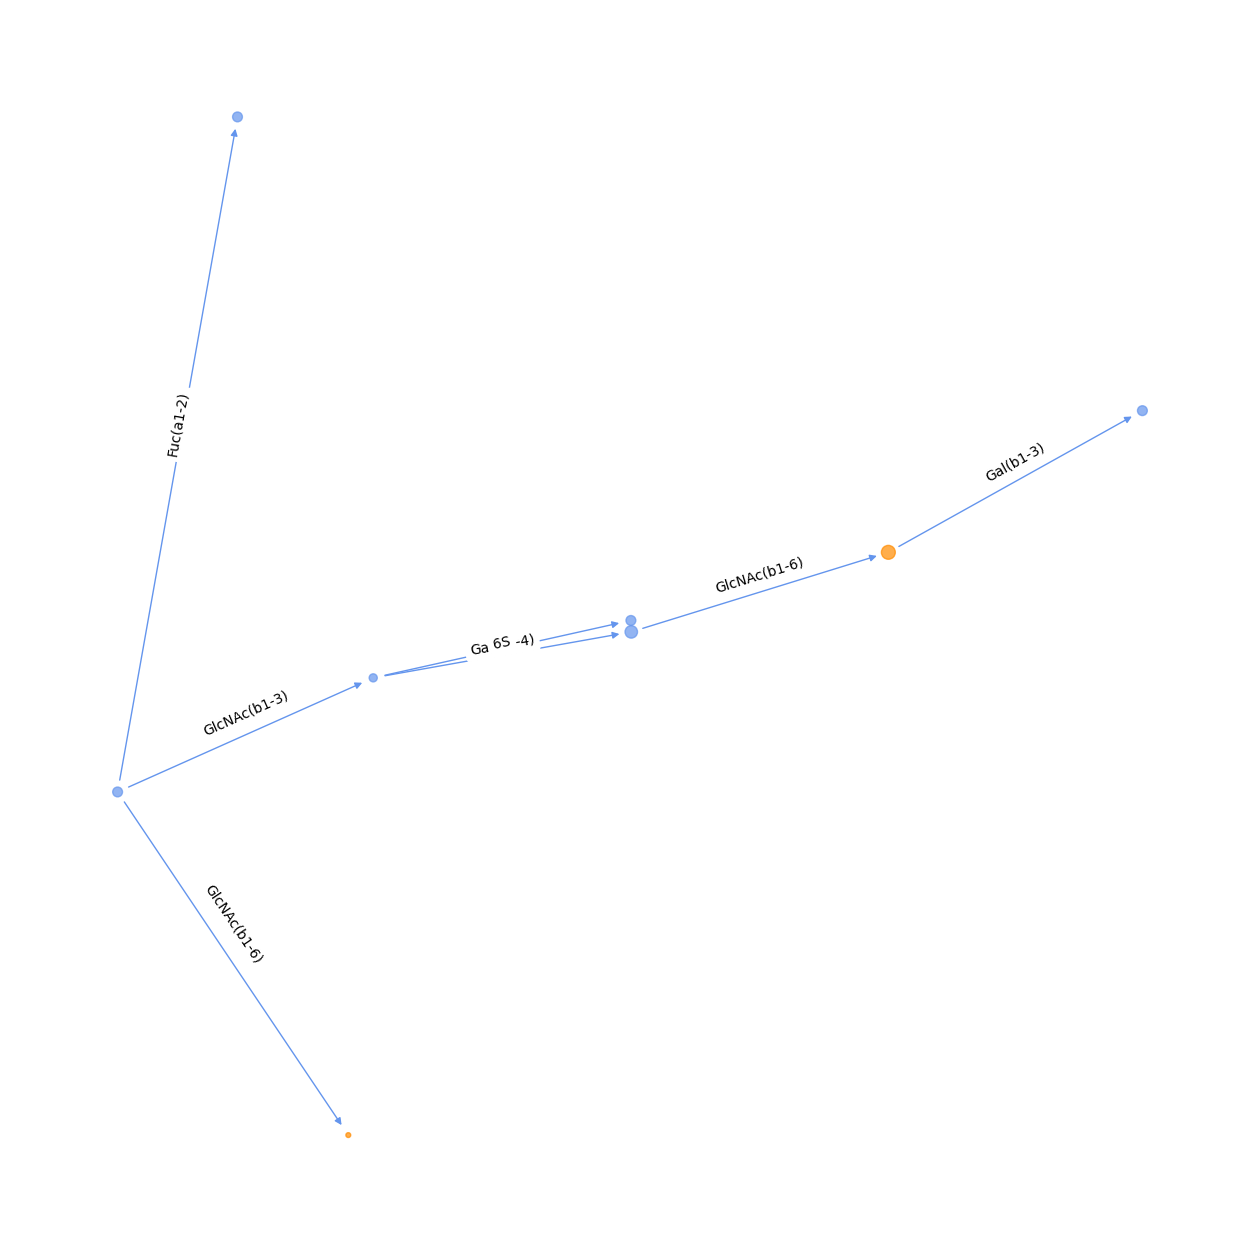

In [ ]:
print(len(network.edges()))
network = evoprune_network(network)
print(len(network.edges()))
plot_network(network, plot_format = 'kamada_kawai')

Nice, that's a bit more organized! `evoprune_network` has removed a few of the nodes that had zero probability. You can see that the orange nodes have changed size as well. This is to indicate their probability. If you change the `threshold` parameter of `evoprune_network` these low-probability nodes might also be pruned away, yet network connectivity is always preserved. <br>

Now, let's say we want to highlight parts of the network containing the monosaccharide Fuc. For this, we can use `glycowork.network.biosynthesis.highlight_network`. With this function, you can highlight many things in a network: motifs, abundances, species occurence, evolutionary conservation, etc.

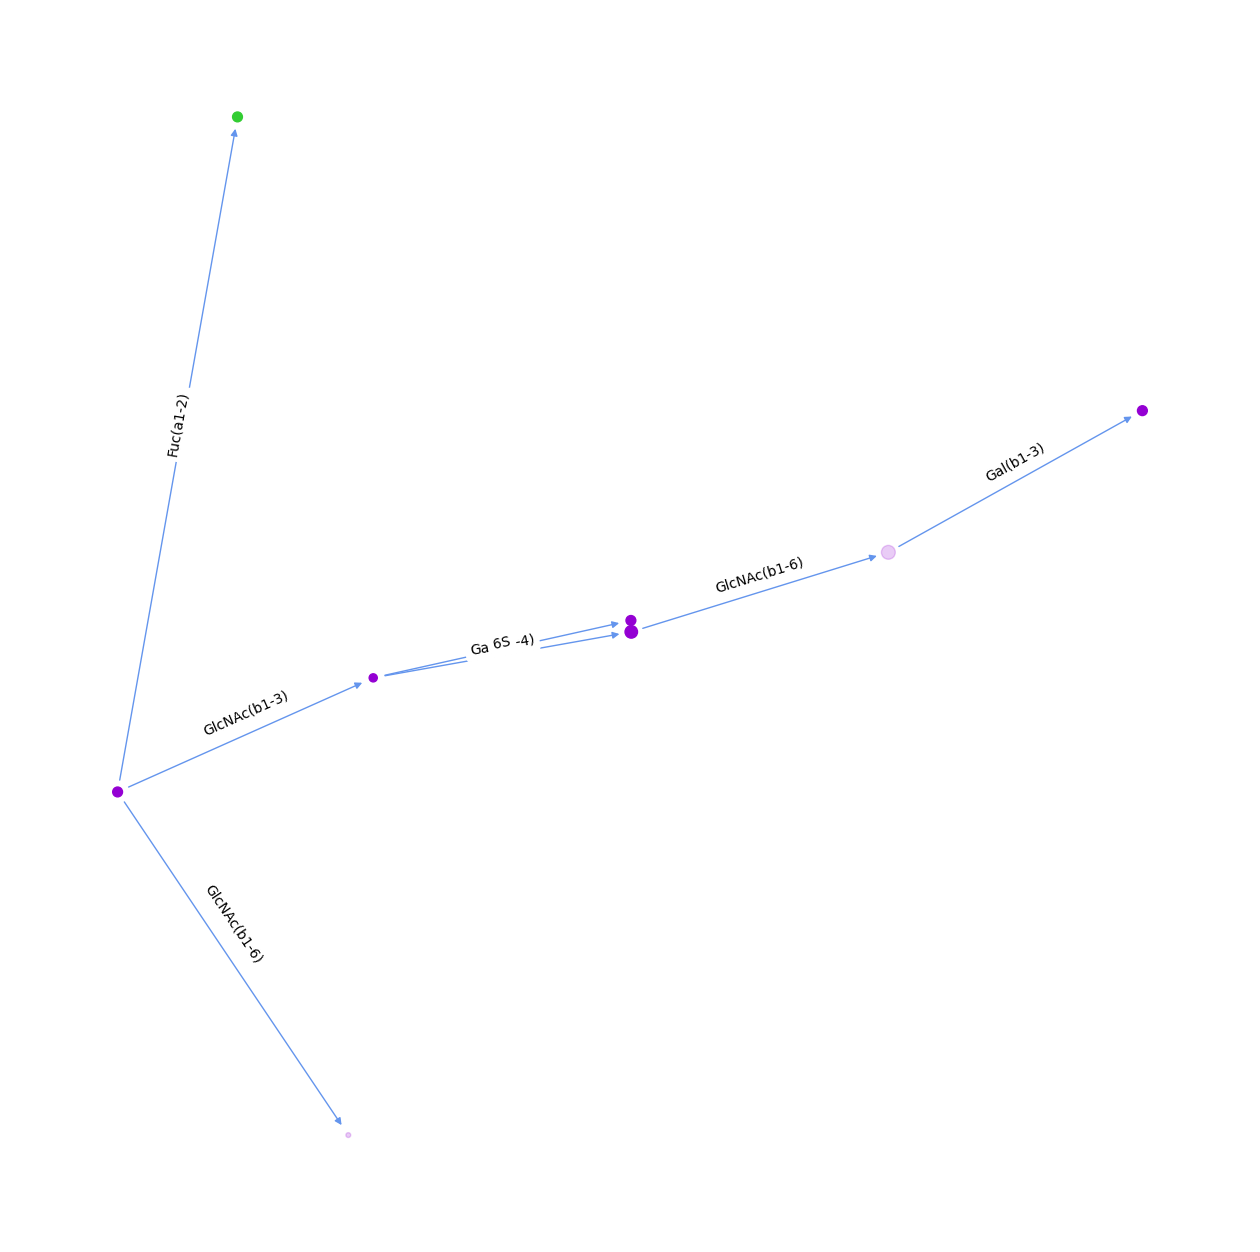

In [ ]:
network = highlight_network(network, 'motif', motif = 'Fuc')
plot_network(network, plot_format = 'kamada_kawai')

You can see that the node color has changed now. Every glycan/node that contains Fuc now is showing up as a green node, while those lacking Fuc are purple. You can also still make out which nodes are inferred (transparent) and actually observed (solid). The probabilities from `evoprune_network`are also still contained within the network. Apart from these visualizations, you can use these networks for all kinds of analytical work, from `glycowork.motif.graph.generate_graph_features` to `glycowork.network.evolution.get_communities`; your only limitation is your creativity!:-)

We can also use the functions within `glycowork.network` to compare species and their milk glycomes:
Let's have a look at the two pre-computed biosynthetic networks (found in net_dic) of black bears (_Ursus americanus_) and brown bears (_Ursus arctos_).

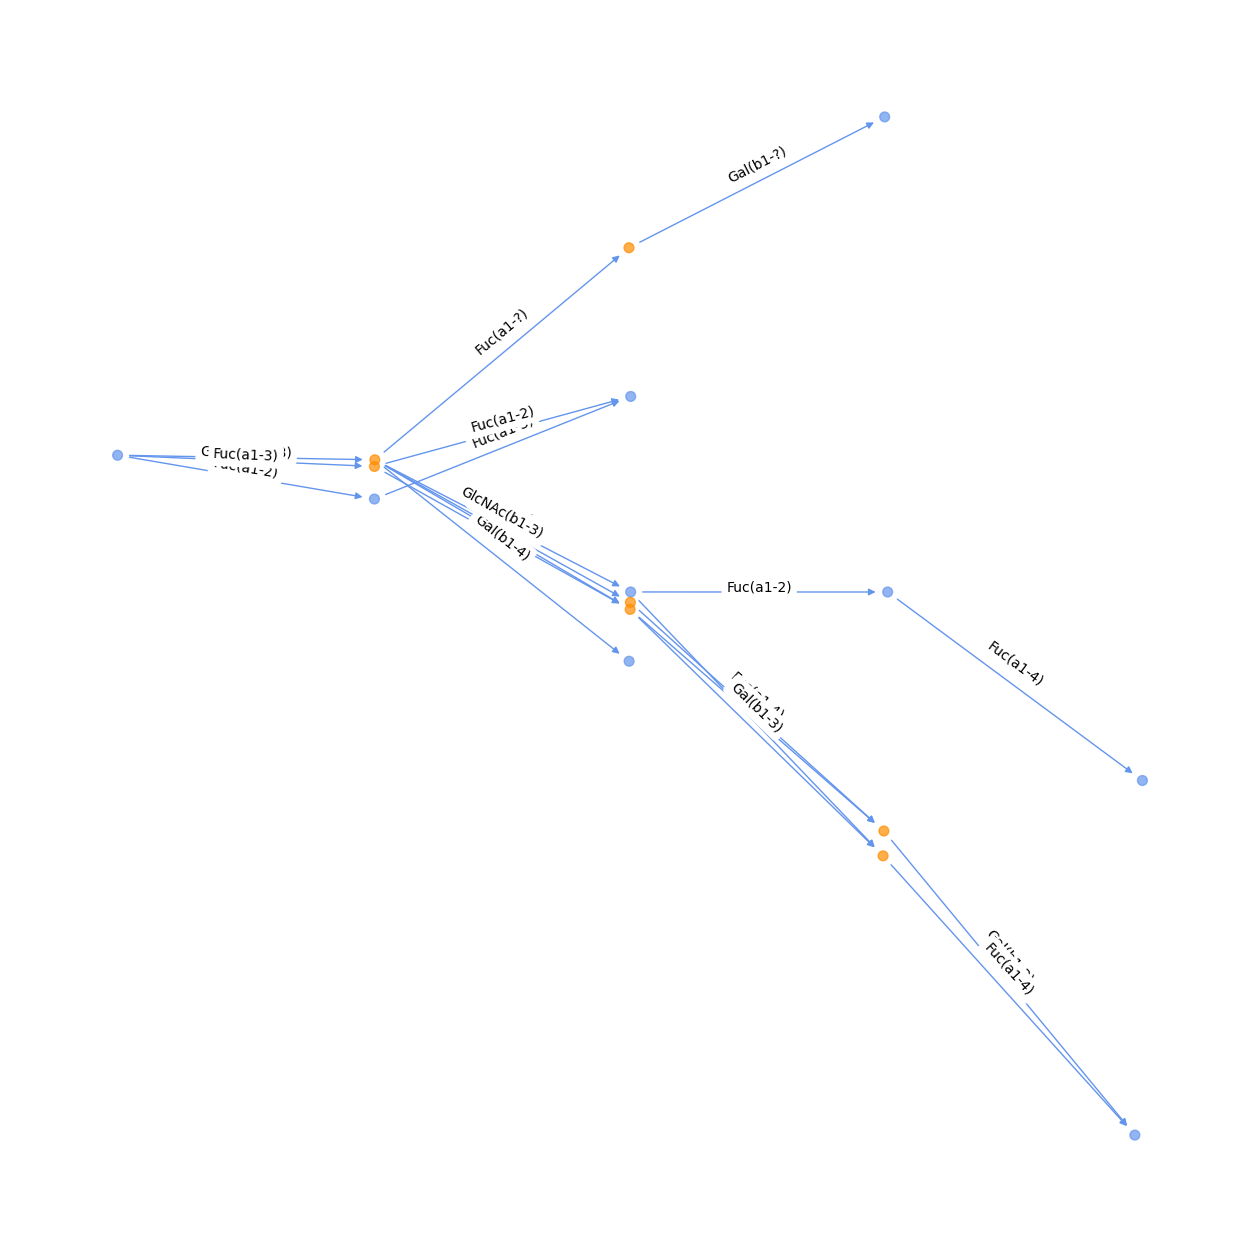

In [ ]:
blackbear_network = net_dic['Ursus_americanus']
brownbear_network = net_dic['Ursus_arctos']
plot_network(network = brownbear_network, plot_format = 'kamada_kawai')

As in our example we have two networks, it is possible to directly combine and compare them to identify conserved and specific nodes, using for instance `glycowork.network.biosynthesis.network_alignment`.

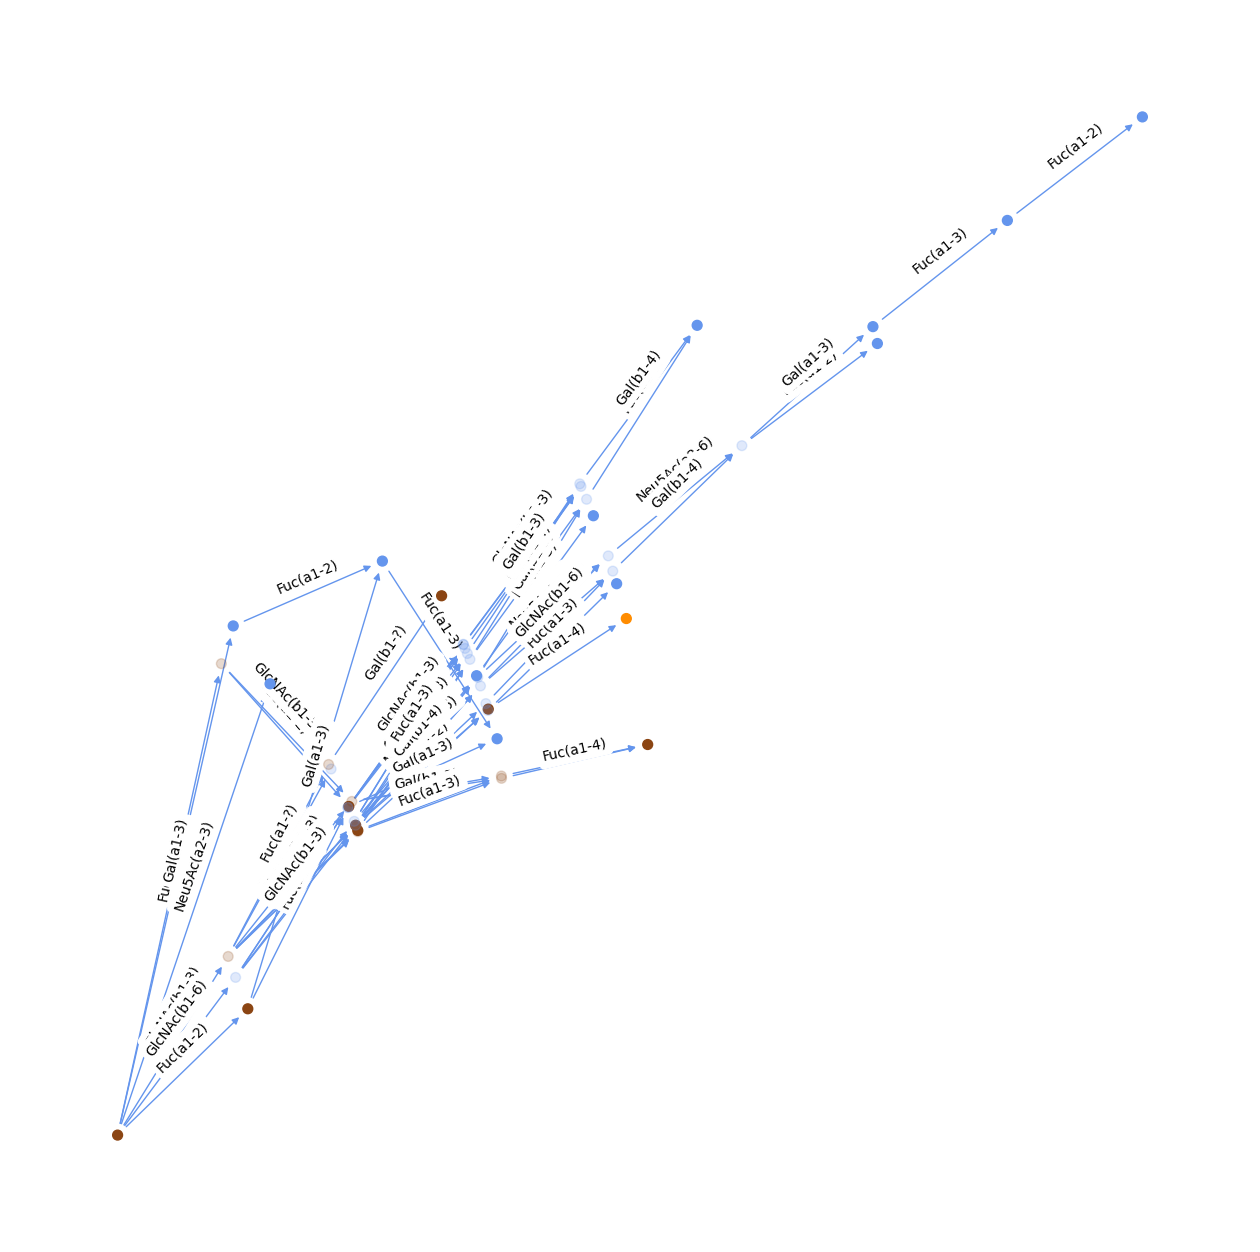

In [ ]:
combined_network = network_alignment(network_a = blackbear_network, network_b = brownbear_network)
plot_network(network = combined_network, plot_format = 'kamada_kawai')

In this new representation, the blue nodes are specific to network_a (here the black bear), and orange nodes are specific to network_b (the brown bear). The remaining brown nodes are conserved in both species. Virtual nodes follow the same color scheme but are transparent. Here, we can see many blue nodes that are specific to the black bear. This is not so surprising, as the black bear network is larger.  

We can also make use of the `network.evolution` module to compare the similarity of related species, such as different kinds of bears. Using the metric of Jaccard distance between their networks, we can retrieve sequences and networks for various bear species within `glycowork` with the function `glycowork.network.evolution.distance_from_metric`. Then, we can use the distance matrix in the `glycowork.network.evolution.dendrogram_from_distance` function to plot the resulting clustering. One immediate result here is that polar bears (_Ursus maritimus_) seem to have a very different milk glycome from other types of bears!

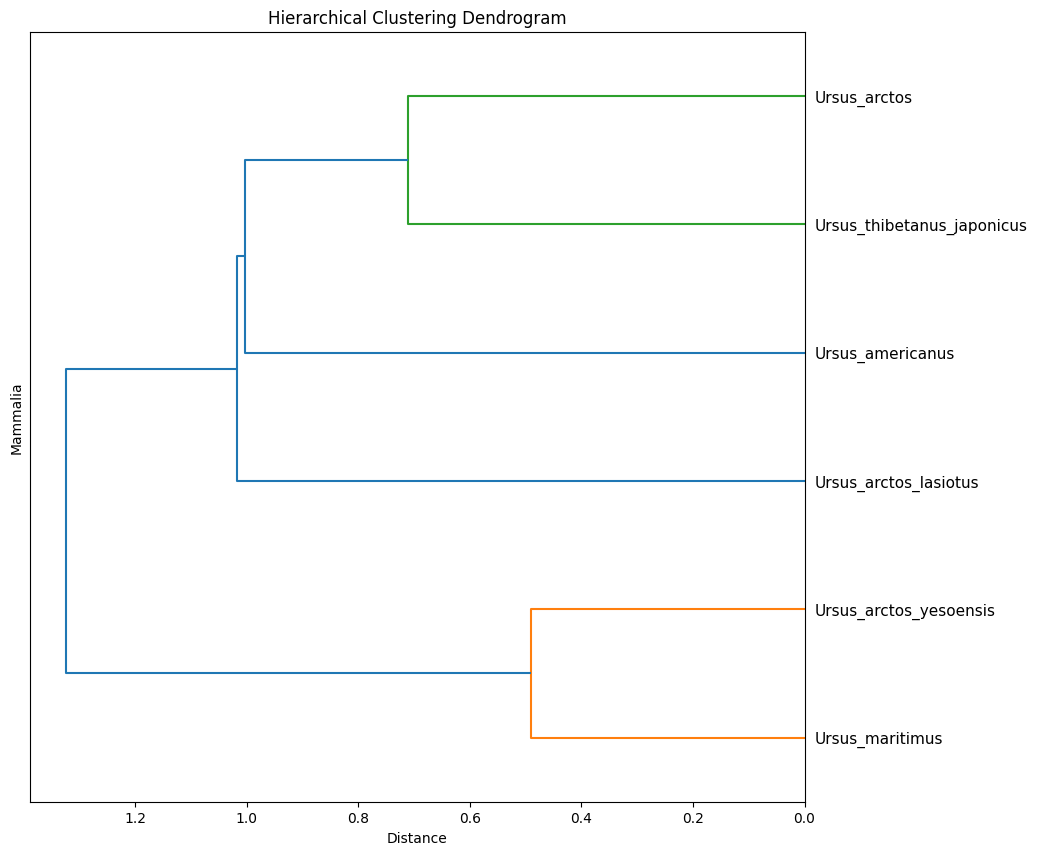

In [ ]:
bears = [net_dic[k] for k in set(list(net_dic.keys())) if 'Ursus' in k]
df_bears = df_species[df_species.Genus=='Ursus'].reset_index(drop = True)
dm = distance_from_metric(df_bears, bears, cut_off = 5)
dendrogram_from_distance(dm)

In [ ]:
#| echo: false
dm.index = dm.columns.tolist()
dm.style.set_properties(**{'font-size': '11pt', 'font-family': 'Helvetica','border-collapse': 'collapse','border': '1px solid black'})

,Ursus_americanus,Ursus_thibetanus_japonicus,Ursus_maritimus,Ursus_arctos,Ursus_arctos_yesoensis,Ursus_arctos_lasiotus
Ursus_americanus,0.000000,0.681818,0.852174,0.721311,0.829545,0.693878
Ursus_thibetanus_japonicus,0.681818,0.000000,0.828571,0.500000,0.867470,0.854167
Ursus_maritimus,0.852174,0.828571,0.000000,0.882353,0.345238,0.958333
Ursus_arctos,0.721311,0.500000,0.882353,0.000000,0.866667,0.850000
Ursus_arctos_yesoensis,0.829545,0.867470,0.345238,0.866667,0.000000,0.940299
Ursus_arctos_lasiotus,0.693878,0.854167,0.958333,0.850000,0.940299,0.000000


# Example 5: Differential glycomics analyses
<a class="anchor" id="example5"></a>

Let's say you have collected glycomics data from healthy and diseased samples and now you want to find out what's really different between the two. There are many ways that you can go about this, depending on your exact question but the most likely answer to your question can be found in the `glycowork.motif.analysis.get_differential_expression` function. This function allows you to test whether any sequences (or motifs) are exhibiting significantly different abundances between your conditions.

But first, we need some data! Now, maybe you have your own data here but you can also easily access the glycomics data stored within `glycowork` via the `glycowork.glycan_data.loader.glycomics_data_loader`. Using `dir(glycomics_data_loader)` will tell you which datasets are currently available (hint: there are also analogous dataloaders for glycoproteomics and lectin microarray data). This example will work with a skin cancer _O_-glycomics dataset but feel free to use your own data if you have it.

In [ ]:
df = glycomics_data_loader.human_skin_O_PMC5871710

In [ ]:
#| echo: false
df.style.set_properties(**{'font-size': '11pt', 'font-family': 'Helvetica','border-collapse': 'collapse','border': '1px solid black'})

,glycan,control_1,tumor_1,control_2,tumor_2,control_3,tumor_3,control_4,tumor_4,control_5,tumor_5,control_6,tumor_6,control_7,tumor_7,control_8,tumor_8,control_9,tumor_9
0,GalOS(b1-3)[Neu5Ac(a2-6)]GalNAc,2.755913,0.620301,3.019806,4.148615,2.413021,0.424605,1.764977,0.744528,4.518547,0.849240,3.174455,1.543922,3.752813,1.287601,1.574444,0.627539,4.415230,0.425039
1,Gal(b1-3)[Neu5Ac(a2-6)]GalNAc,0.775234,0.178490,0.778083,0.832907,0.824018,0.410873,0.617573,2.133773,0.603573,0.544599,1.317444,1.256997,0.860332,0.340373,0.927956,0.494144,1.045950,0.590404
2,Neu5Ac(a2-3)Gal(b1-3)GalNAc,9.219494,8.436141,16.190721,11.032313,16.061363,8.133529,12.291188,10.143781,10.865172,14.353894,12.313024,11.601938,13.246380,8.352032,12.352587,9.731834,16.170263,12.693331
3,Gal(b1-4)GlcNAc(b1-6)[Gal(b1-3)]GalNAc,2.770825,0.944913,1.531698,2.427562,1.570204,2.066165,2.832475,2.508954,2.228299,1.757840,4.811796,3.641077,1.437487,1.470697,2.324956,2.192553,0.805130,1.100490
4,Neu5Ac(a2-3)Gal(b1-3)[Neu5Ac(a2-6)]GalNAc,35.912676,30.058418,48.420833,43.738436,46.692847,26.728713,39.971128,32.290024,51.472292,40.669153,41.927351,37.755641,43.701528,32.565498,47.145757,38.565763,44.683562,33.532942
5,Neu5Ac(a2-3)Gal(b1-3)[Neu5Ac(a2-8)Neu5Ac(a2-6)]GalNAc,0.664610,0.495280,1.451470,1.289237,1.331164,0.441114,0.657772,0.330536,0.654086,0.219399,1.433102,0.791533,0.722264,0.589715,1.337691,0.779090,1.734299,0.605036
6,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-6)[Gal(b1-3)]GalNAc,1.069934,1.735744,1.468105,1.509499,1.128653,1.812381,0.816789,6.345353,2.179460,1.261105,1.438459,4.410718,0.669910,1.310332,1.838577,0.989791,1.329698,1.392818
7,Neu5Ac(a2-3)Gal(b1-3)[Gal(b1-4)GlcNAc6S(b1-6)]GalNAc,0.599954,1.213936,0.450138,0.469515,0.528332,2.891749,0.770085,0.853955,0.853148,4.776427,0.669361,1.323619,0.914651,1.027152,1.633415,4.333793,0.365928,3.162330
8,Neu5Ac(a2-3)Gal(b1-4)GlcNAc6S(b1-6)[Gal(b1-3)]GalNAc,6.005921,6.365952,5.623333,5.965819,5.299405,7.027606,10.523154,12.570391,4.753029,6.895145,12.325022,10.338465,5.401390,5.785955,7.054084,5.775716,11.549820,4.633692
9,Neu5Ac(a2-3)Gal(b1-3)[Gal(b1-4)GlcNAc(b1-6)]GalNAc,3.557548,2.179078,2.341708,2.594836,2.408925,1.838783,3.403741,1.561446,1.909720,0.838742,1.389057,1.590800,2.557034,3.846191,0.765387,0.660688,1.428603,0.845144


We can see that the dataset is structured as having the glycans in the very first column and then every sample being another column. This is the standard set-up that most functions in `glycowork.motif.analysis` expect to get. Note that, while glycans here are written in IUPAC-condensed, you can use pretty much any common glycan nomenclature (WURCS, GlycoCT, IUPAC-extended, etc.) and our internal conversions will make it work.

Now `glycowork.motif.analysis.get_differential_expression` basically only needs to know two things: (i) your dataset and (ii) which columns belong to which condition. There are many more options and settings that you *can* choose, but that's the minimum. Our example dataset tell us in the column headings which sample comes from a tumor and which from a healthy setting. Our function now wants to know either the position of the column or the column names of both the control samples and the disease samples. We will further use one optional setting, "paired = True", to indicate that these samples are matched (control_1 and tumor_1 come from the same patient). Analyzing paired samples in a paired manner is not only more sensitive but also more appropriate, statistically speaking.

So, let's see which glycans are differentially abundant in skin cancers!

In [ ]:
get_differential_expression(df, [1,3,5,7,9,11,13,15,17], [2,4,6,8,10,12,14,16,18], paired = True)

You're working with an alpha of 0.05632533070968504 that has been adjusted for your sample size of 18.


,Glycan,Mean abundance,Log2FC,p-val,corr p-val,significant,corr Levene p-val,Effect size,Equivalence p-val
12,Neu5Ac(a2-3)Gal(b1-4)GlcNAc6S(b1-6)[Neu5Ac(a2-...,4.420991,1.283490,0.000606,0.002039,True,0.310892,1.817887,1.00000
8,Neu5Ac(a2-3)Gal(b1-3)[Neu5Ac(a2-8)Neu5Ac(a2-6)...,0.862634,-0.960937,0.001018,0.002039,True,0.895209,-1.675611,1.00000
10,Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-6)[Neu5Ac(a2-3)...,16.493965,0.466816,0.001019,0.002039,True,0.895209,1.675275,1.00000
3,GalOS(b1-3)[Neu5Ac(a2-6)]GalNAc,2.114478,-1.599542,0.001568,0.002352,True,0.739689,-1.562235,1.00000
9,Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-6)[Gal(b1-3)]Ga...,8.822736,0.754260,0.004391,0.005269,True,0.330544,1.308131,1.00000
7,Neu5Ac(a2-3)Gal(b1-3)[Neu5Ac(a2-6)]GalNAc,39.768471,-0.353724,0.009539,0.009539,True,0.310892,-1.129075,1.00000
6,Neu5Ac(a2-3)Gal(b1-3)[Gal(b1-4)GlcNAc6S(b1-6)]...,1.490972,1.285978,0.013525,0.013525,True,0.310892,1.051192,1.00000
4,Neu5Ac(a2-3)Gal(b1-3)GalNAc,11.843832,-0.341960,0.092857,0.092857,False,0.892108,-0.635907,0.91601
5,Neu5Ac(a2-3)Gal(b1-3)[Gal(b1-4)GlcNAc(b1-6)]Ga...,1.984302,-0.330469,0.106619,0.106619,False,0.892108,-0.605916,0.91601
0,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-6)[Gal(b1-3)]GalNAc,1.817074,0.576828,0.171753,0.171753,False,0.847183,0.500330,0.91601


Okay, seems like there are quite a few glycan that are either higher or lower in the cancer samples (see the "Log2FC" or "Effect size" columns for the direction of the effect)! A really important column here is the "corr p-val" column, which indicates the p-values of the comparisons after a two-stage Benjamini-Hochberg correction for multiple testing. By comparing this with a significance threshold, we can tell whether the observed difference is statistically significant. Usually, this threshold is p < 0.05 but this is a bad convention, since the meaning of p-values changes with sample size (a p-value of 0.049 at a sample size of 1,000 should not be considered significant but it should at a sample size of 10). `glycowork` adjusts this for you.

If you want to know what's happening under the hood, this function is transforming your data via a CLR-transformation with a scale uncertainty model to counteract (i) the compositional nature of glycomics data and (ii) potential absolute differences between your conditions. In any case, let's now have a look at motifs/substructures! While you can further specify which motifs you want to look at via the "feature_set" option, simply switching on "motifs = True" can be sufficient to now analyze at the motif level.

In [ ]:
df_res = get_differential_expression(df, [1,3,5,7,9,11,13,15,17], [2,4,6,8,10,12,14,16,18], paired = True, motifs = True)
df_res

You're working with an alpha of 0.05632533070968504 that has been adjusted for your sample size of 18.


,Glycan,Mean abundance,Log2FC,p-val,corr p-val,significant,corr Levene p-val,Effect size,Equivalence p-val
3,Terminal_LacNAc_type2,3.199188,0.550662,0.000387,0.001717,True,0.755837,1.946637,1.000000
7,Neu5Ac(a2-6)GalNAc,1.578713,-0.415175,0.000832,0.001717,True,0.755837,-1.730111,1.000000
8,Mucin_elongated_core2,4.825130,0.454891,0.001318,0.001717,True,0.755837,1.607370,1.000000
2,GalOS(b1-3)GalNAc,0.252764,-1.660997,0.001486,0.001717,True,0.755837,-1.576204,1.000000
6,Disialyl_T_antigen,0.488585,-0.371793,0.001717,0.001717,True,0.755837,-1.539039,1.000000
0,Neu5Ac(a2-8)Neu5Ac,0.102803,-0.900084,0.002711,0.002711,True,0.937258,-1.424536,1.000000
5,GlcNAc6S(b1-6)GalNAc,3.199188,0.522769,0.011365,0.011365,True,0.755837,1.089828,1.000000
11,Gal,7.907379,0.165564,0.019270,0.019270,True,0.755837,0.973579,1.000000
9,Oglycan_core1,5.174125,-0.179318,0.051359,0.051359,True,0.755837,-0.762940,0.942589
10,Neu5Ac(a2-3)Gal,3.687773,0.123534,0.084052,0.084052,False,0.755837,0.657413,0.942589


So here we see now that extended core 2 structures, especially sulfated ones, are significantly increasing in cancer, whereas core 1 structures do not change significantly. What's interesting here is that most forms of sialylation are in fact decreasing in cancer, despite the typical finding that sialylation increases in tumor and despite the fact that there are individual sialylated structures that significantly increase. On the one hand, this of course depends on the tumor / type of cancer. But it's very important to keep that this is precisely why it's key to analyze glycomics data at the motif level to get an overall picture, as the intuition can often be led astray by looking at individual structures.

Okay, last but not least, let's make a volcano plot with the results we got from the motif-level analysis! For this, we can use the `glycowork.motif.analysis.get_volcano` function, which takes the output from `glycowork.motif.analysis.get_differential_expression` and can also be further styled with `GlycoDraw` as is discussed below.

You're working with an alpha of 0.05632533070968504 that has been adjusted for your sample size of 18.


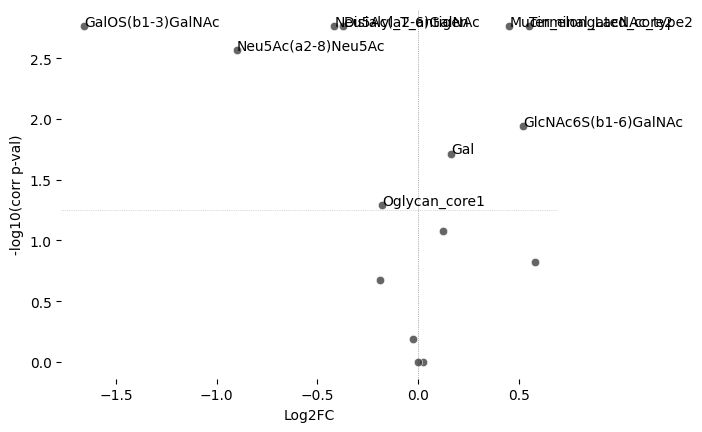

In [ ]:
get_volcano(df_res, n = 18)

# Deep Learning Code Snippets
<a class="anchor" id="example5"></a>

For those of you that are blessed with GPU-access, we wrote up a minimal example for training a glycan-focused deep learning model. Even if you usually do not have access to a GPU, you can always go to Google Colab (click on the badge at the top of this site to open this notebook on Google Colab) and change the runtime type to GPU. Then you can paste the following code in a cell, execute, and see our model train!

First, we need to install torch_geometric for deep learning (keep the package versions; especially if you want to use our trained models):

```
!pip install torch==2.1
!pip install torch-geometric==2.4
```

Alternatively, if you've installed `glycowork` like this, you likely have everything in place already:

```
pip install glycowork[ml]
```

*SweetNet-type model*

Then, we import the relevant `glycowork` modules:

```
from glycowork.glycan_data.loader import df_species
from glycowork.ml.train_test_split import hierarchy_filter
from glycowork.ml.processing import split_data_to_train
from glycowork.ml import models
from glycowork.ml import model_training
```

Finally, we can prepare the data and train a model to classify from which taxonomic kingdom a glycan came from, using our graph convolutional neural network, `SweetNet`.

```
train_x, val_x, train_y, val_y, id_val, class_list, class_converter = hierarchy_filter(df_species,
                                                                                       rank = 'Kingdom')

dataloaders = split_data_to_train(train_x, val_x, train_y, val_y)
model = models.prep_model('SweetNet', len(class_list))
optimizer_ft, scheduler, criterion = model_training.training_setup(model, 0.0005, num_classes = len(class_list))
model_ft = model_training.train_model(model, dataloaders, criterion, optimizer_ft, scheduler,
                   num_epochs = 100)
```

And that's it! You've just trained a state-of-the-art deep learning model with effectively five lines of code (excluding package imports of course).

*LectinOracle-type model*

For `LectinOracle`, you need a protein sequence and glycan sequences. Further, you will need to retrieve the ESM1b-representation for your protein sequence, as that is used as the actual input for LectinOracle. If you don't want to do that, check below for the `LectinOracle_flex` model. Here the minimal process is shown for the arbitrary protein sequence "QWERTFVCF". The trained model is yet again retrieved via `prep_model`.

```
!pip install fair-esm
import esm
from glycowork.ml.inference import get_esm1b_representations, get_lectin_preds
from glycowork.ml.models import prep_model

model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
rep = get_esm1b_representations(["QWERTFVCF"], model, alphabet)
leor = prep_model("LectinOracle", 1, trained = True)
get_lectin_preds("QWERTFVCF", ['Neu5Ac(a2-6)GalNAc', 'Gal(b1-4)Glc'], leor, rep)
```

The output here (same as for `LectinOracle_flex` below) is a table/dataframe, where each row shows the tested glycan and its associated binding prediction. The higher the binding prediction, the more likely an interaction (negative values in general likely mean "no interaction"), with a moderate correlation with binding affinity (based on our findings so far).

*LectinOracle_flex-type model*

While it has a slightly lower performance than `LectinOracle`, `LectinOracle_flex` can directly use protein sequences as input (no ESM1b-conversion necessary). This is made possible by knowledge distillation, in which we train a sub-module to mimic the conversion of the much larger ESM1b model. Just get the correct model via `prep_model` and declare `flex = True` and you're good to go!

```
from glycowork.ml.inference import get_lectin_preds
from glycowork.ml.models import prep_model
leor = prep_model("LectinOracle_flex", 1, trained = True)
get_lectin_preds("QWERTFVCF", ['Neu5Ac(a2-6)GalNAc', 'Gal(b1-4)Glc'], leor, flex = True)
````

# GlycoDraw Code Snippets
<a class="anchor" id="example6"></a>

Remember, if you want to use anything from `glycowork.motif.draw`, you will need to install glycowork with the corresponding optional installs:
```
pip install glycowork[draw]
```
If you're working in Google Colaboratory, this will be enough. If you work locally, you might need to add the optional install below for full functionality. In-line plotting and .svg exports should work even without this. But .pdf exports might require this optional install.

_Linux_
```
apt install libcairo2-dev
```
_macOS_ (homebrew package manager)
```
brew install cairo pkg-config
```
_Windows_ <br>
- install latest .exe from https://github.com/tschoonj/GTK-for-Windows-Runtime-Environment-Installer/releases <br>
- make sure that the \GTK3-Runtime directory is in your Path environment variable (ideally at the top) <br>

Remember, you might not need this last optional install. In any case, after this, you can just run:
```
from glycowork.motif.draw import GlycoDraw
```
and you're good to go!

Let's try it:

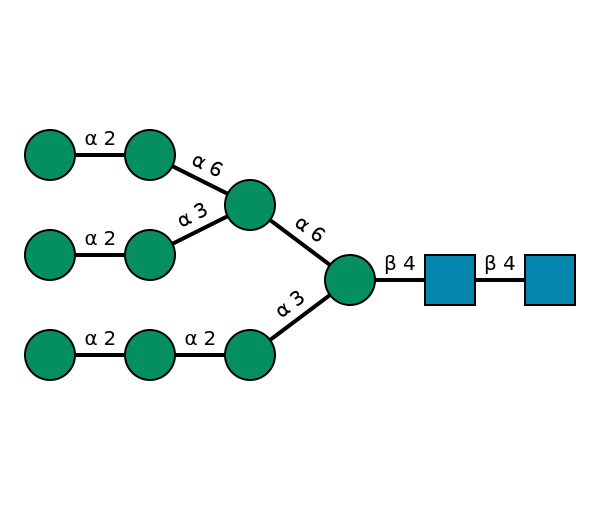

In [ ]:
GlycoDraw('Man(a1-2)Man(a1-2)Man(a1-3)[Man(a1-2)Man(a1-3)[Man(a1-2)Man(a1-6)]Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc')

Okay, that's all nice and well. But what if you don't have lots of space in your figure?

Enter `compact = True`

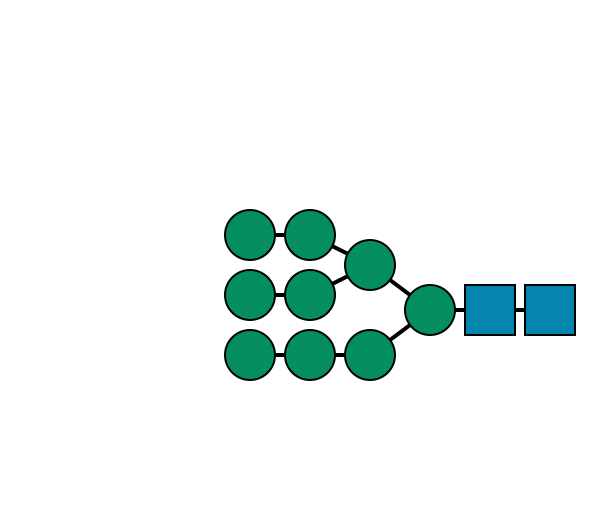

In [ ]:
GlycoDraw('Man(a1-2)Man(a1-2)Man(a1-3)[Man(a1-2)Man(a1-3)[Man(a1-2)Man(a1-6)]Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc',
         compact = True)

You can also go beyond mere drawing and add some more information, such as motif highlighting! In the below example, we highlight all Lewis antigen motifs in that structure.

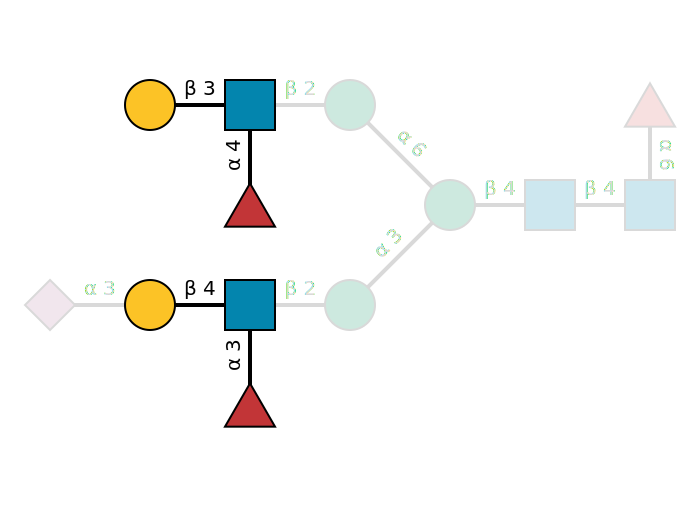

In [ ]:
GlycoDraw('Neu5Ac(a2-3)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-2)Man(a1-3)[Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc',
         highlight_motif = 'Fuc(a1-?)[Gal(b1-?)]GlcNAc')

Or you could draw repeat structures, such as in glycosaminoglycans (GAGs). Here's one example:

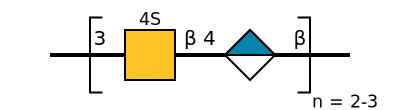

In [ ]:
GlycoDraw('GalNAc4S(b1-4)GlcA(b1-3)', repeat = '2-3')

Or how about visualizing flexibility, attention, or any kind of attribution on a per-monosaccharide basis?

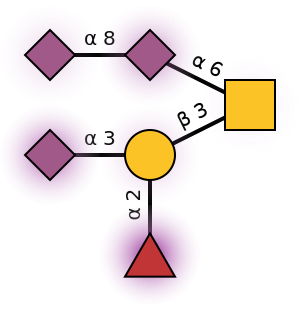

In [ ]:
GlycoDraw("Fuc(a1-2)[Neu5Ac(a2-3)]Gal(b1-3)[Neu5Ac(a2-8)Neu5Ac(a2-6)]GalNAc", per_residue = [0.9, 0.7, 0.3, 0.2, 0.5, 0.1])

And that's only a brief glimpse at the offered functionality! Why not replace the text labels from `glycowork.motif.analysis.get_heatmap` or `glycowork.motif.analysis.get_volcano` with glycan images via `glycowork.motif.draw.annotate_figure`?

Be sure to check out Lundstrøm et al., _Glycobiology_, 2023 for more details and inspirations!

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()